- day + animal + sex
- experiment + animal + sex
- comparison top 10 to rest in both


Expectations:
- variation across different experiments and gap lengths
- stronger in female mice
- variation across recording days without pattern
- stronger in first 10 recordings

Sex: nominal chi-squared
Weight: interval/ratio 
Strength: interval/ratio 
Reaction Time: interval/ratio 
Recording Day: nominal
Experiment type: nominal


reaction time non-parametric, strength normally distributed!


H0s:
1: no correlation between weight and strength if normalized -> extra weight does not indicate more muscle mass (no correlation, Pearson test)
2: no relationship between sex and strength (if strength normalized for weight? Maybe with and without normalization?) (independant two paired groups, ind. t-test and ANCOVA with weight as covariable) 
3: no influence of sex on reaction time (independant, Mann–Whitney U Test)
4: no relationship between day of measurement and strength and reaction time (ANOVA (norm, for strength), Friedman (non-para, for reaction time) OR linear mixed model)
5: first 10 recordings do not differ in strength or reaction time
6: experiment type has no influence on strength or reaction time


4th recording day would only help clarify effect of day and age

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare, kruskal, kstest, \
    lognorm, gamma, weibull_min, probplot, f_oneway, linregress, norm, spearmanr, ttest_1samp, wilcoxon
import seaborn as sns
import os
import ast
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [106]:

# Load CSV
df = pd.read_excel("Results/merged reps/Output.xlsx")

# Parse stringified lists into real lists
for col in ['reactionTime', 'peakTime', 'strength']:
    df[col] = df[col].apply(ast.literal_eval)

# Function to compute trend (slope) for each list
def compute_trend(values):
    if len(values) < 2:
        return None  # Not enough data for a trend
    x = list(range(len(values)))  # repetition indices: 0, 1, 2, ...
    slope, intercept, r_value, p_value, std_err = linregress(x, values)
    return slope

# Apply function to each row
df['reactionTime_trend'] = df['reactionTime'].apply(compute_trend)
df['peakTime_trend'] = df['peakTime'].apply(compute_trend)
df['strength_trend'] = df['strength'].apply(compute_trend)

# Example: See results
print(df[['animal', 'experiment', 'reactionTime_trend', 'peakTime_trend', 'strength_trend']])

       animal       experiment  reactionTime_trend  peakTime_trend  \
0     Animal1      ASR_control                 0.0             0.0   
1     Animal1        gap_depth                -0.2             0.0   
2     Animal1    tone_in_noise                 1.2             0.0   
3     Animal1   gap_duration_4                 0.0             0.0   
4     Animal1   gap_duration_8                 0.0             1.8   
..        ...              ...                 ...             ...   
139  Animal15   gap_duration_4                 1.4            -0.2   
140  Animal15   gap_duration_8                 0.0            -0.2   
141  Animal15  gap_duration_10                 0.2            -0.4   
142  Animal15  gap_duration_20                -0.8            -0.2   
143  Animal15  gap_duration_50                 1.2            -4.0   

     strength_trend  
0              -0.1  
1               0.5  
2              -3.0  
3               2.1  
4               2.0  
..              ...  
139  

In [107]:
df.groupby('experiment')[['reactionTime_trend', 'peakTime_trend', 'strength_trend']].mean()

,reactionTime_trend,peakTime_trend,strength_trend
experiment,,,
ASR_control,0.033333,-0.444444,-1.800000
gap_depth,0.022222,-0.111111,-1.033333
gap_duration_10,-0.088889,-0.700000,-1.688889
gap_duration_20,0.088889,-0.888889,-0.988889
gap_duration_4,-0.033333,0.066667,0.600000
gap_duration_50,0.066667,-1.022222,-1.650000
gap_duration_8,0.066667,0.344444,-1.888889
tone_in_noise,0.155556,0.200000,-0.466667


In [108]:
for col in ['reactionTime_trend', 'peakTime_trend', 'strength_trend']:
    t_stat, p_val = ttest_1samp(df[col].dropna(), 0)
    print(f"{col}: t = {t_stat:.2f}, p = {p_val:.4f}")

reactionTime_trend: t = 0.63, p = 0.5288
peakTime_trend: t = -1.71, p = 0.0886
strength_trend: t = -3.35, p = 0.0010


In [109]:
for col in ['reactionTime_trend', 'peakTime_trend', 'strength_trend']:
    data = df[col].dropna()
    
    if col == 'strength_trend':
        # Use Wilcoxon signed-rank test for non-normal data
        stat, p_val = wilcoxon(data - 0)
        print(f"{col} (Wilcoxon): stat = {stat:.2f}, p = {p_val:.4f}")
    else:
        # Use one-sample t-test for normal data
        t_stat, p_val = ttest_1samp(data, 0)
        print(f"{col}: t = {t_stat:.2f}, p = {p_val:.4f}")

reactionTime_trend: t = 0.63, p = 0.5288
peakTime_trend: t = -1.71, p = 0.0886
strength_trend (Wilcoxon): stat = 3124.00, p = 0.0000


In [110]:
for measure in ['reactionTime_trend', 'peakTime_trend', 'strength_trend']:
    for exp in df['experiment'].unique():
        exp_data = df[df['experiment'] == exp][measure].dropna()
        t, p = ttest_1samp(exp_data, 0)
        print(f"{exp} - {measure}: t = {t:.2f}, p = {p:.4f}")

ASR_control - reactionTime_trend: t = 0.17, p = 0.8639
gap_depth - reactionTime_trend: t = 0.21, p = 0.8381
tone_in_noise - reactionTime_trend: t = 0.44, p = 0.6637
gap_duration_4 - reactionTime_trend: t = -0.22, p = 0.8250
gap_duration_8 - reactionTime_trend: t = 0.49, p = 0.6309
gap_duration_10 - reactionTime_trend: t = -0.69, p = 0.5020
gap_duration_20 - reactionTime_trend: t = 0.73, p = 0.4734
gap_duration_50 - reactionTime_trend: t = 0.70, p = 0.4953
ASR_control - peakTime_trend: t = -0.68, p = 0.5066
gap_depth - peakTime_trend: t = -0.25, p = 0.8026
tone_in_noise - peakTime_trend: t = 0.81, p = 0.4280
gap_duration_4 - peakTime_trend: t = 0.17, p = 0.8662
gap_duration_8 - peakTime_trend: t = 0.99, p = 0.3339
gap_duration_10 - peakTime_trend: t = -1.22, p = 0.2406
gap_duration_20 - peakTime_trend: t = -1.12, p = 0.2769
gap_duration_50 - peakTime_trend: t = -1.82, p = 0.0862
ASR_control - strength_trend: t = -2.04, p = 0.0568
gap_depth - strength_trend: t = -1.78, p = 0.0929
tone_in

In [111]:


mean_diff = df['strength_trend'].mean()
std_diff = df['strength_trend'].std()
cohen_d = mean_diff / std_diff
print(f"Cohen's d for strength_trend: {cohen_d:.2f}")


Cohen's d for strength_trend: -0.28


In [112]:
df = pd.read_excel("Results/merged reps/Output.xlsx")

# Parse stringified lists into real lists
for col in ['reactionTime', 'peakTime', 'strength']:
    df[col] = df[col].apply(ast.literal_eval)

def test_trend(data_lists, var_name):
    lengths = [len(lst) for lst in data_lists]
    max_len = max(lengths)
    
    # Pad with nan to equal length
    padded_lists = [lst + [np.nan]*(max_len - len(lst)) for lst in data_lists]
    data_matrix = np.array(padded_lists)
    
    # Average across samples per repetition (skip nan)
    mean_per_rep = np.nanmean(data_matrix, axis=0)
    
    reps = np.arange(1, max_len + 1)
    corr, pval = spearmanr(reps, mean_per_rep)
    
    print(f"{var_name} trend test across repetitions:")
    print(f" Spearman correlation = {corr:.3f}, p-value = {pval:.4f}")

# Example usage:  
# Assuming df['peakTime'] and df['reactionTime'] each contain lists per row:
peaktime_lists = df['peakTime'].dropna().tolist()
reactiontime_lists = df['reactionTime'].dropna().tolist()

test_trend(peaktime_lists, 'peakTime')
test_trend(reactiontime_lists, 'reactionTime')

peakTime trend test across repetitions:
 Spearman correlation = -0.600, p-value = 0.2848
reactionTime trend test across repetitions:
 Spearman correlation = 0.300, p-value = 0.6238


In [113]:
""" 
for sex in df['sex'].dropna().unique():
    for experiment in df['experiment'].dropna().unique():
        subset = df[(df['sex'] == sex) & (df['experiment'] == experiment)]['peakTime_trend'].dropna()
        
        if len(subset) > 0:
            try:
                stat, p_val = wilcoxon(subset - 0)
                print(f"Sex: {sex}, Experiment: {experiment} — Wilcoxon stat = {stat:.2f}, p = {p_val:.4f}")
            except ValueError as e:
                # This happens if all values are zero or sample size too small
                print(f"Sex: {sex}, Experiment: {experiment} — Test not valid: {e}")
        else:
            print(f"Sex: {sex}, Experiment: {experiment} — No data") """

' \nfor sex in df[\'sex\'].dropna().unique():\n    for experiment in df[\'experiment\'].dropna().unique():\n        subset = df[(df[\'sex\'] == sex) & (df[\'experiment\'] == experiment)][\'peakTime_trend\'].dropna()\n        \n        if len(subset) > 0:\n            try:\n                stat, p_val = wilcoxon(subset - 0)\n                print(f"Sex: {sex}, Experiment: {experiment} — Wilcoxon stat = {stat:.2f}, p = {p_val:.4f}")\n            except ValueError as e:\n                # This happens if all values are zero or sample size too small\n                print(f"Sex: {sex}, Experiment: {experiment} — Test not valid: {e}")\n        else:\n            print(f"Sex: {sex}, Experiment: {experiment} — No data") '

In [114]:
input_dir = "Results" # input directory

number = "merged avg" # results to analyze (subfolder name, can be an integer or string)

In [115]:
results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

file_path = os.path.join(results_dir, files[0])
df = pd.read_excel(file_path)

if len([f for f in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, f))]) == 2:
    file_path_top_10 = os.path.join(results_dir, files[1])
    df_top_10 = pd.read_excel(file_path_top_10)
else:
    df_top_10 = None

In [116]:
# Ensure 'sex' is categorical (if not already)
df['sex'] = df['sex'].astype('category')

# Fit linear model with interaction
model = smf.ols('peakTime ~ strength * sex', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               peakTime   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     11.00
Date:                Sat, 05 Jul 2025   Prob (F-statistic):           1.56e-06
Time:                        16:19:11   Log-Likelihood:                -357.26
No. Observations:                 144   AIC:                             722.5
Df Residuals:                     140   BIC:                             734.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               28.3957 

In [117]:
""" for experiment in df['experiment'].dropna().unique():
    subset = df[df['experiment'] == experiment]['peakTime_trend'].dropna()
    
    if len(subset) > 0:
        try:
            stat, p_val = wilcoxon(subset - 0)
            print(f"Experiment: {experiment} — Wilcoxon stat = {stat:.2f}, p = {p_val:.4f}")
        except ValueError as e:
            print(f"Experiment: {experiment} — Test not valid: {e}")
    else:
        print(f"Experiment: {experiment} — No data") """

' for experiment in df[\'experiment\'].dropna().unique():\n    subset = df[df[\'experiment\'] == experiment][\'peakTime_trend\'].dropna()\n    \n    if len(subset) > 0:\n        try:\n            stat, p_val = wilcoxon(subset - 0)\n            print(f"Experiment: {experiment} — Wilcoxon stat = {stat:.2f}, p = {p_val:.4f}")\n        except ValueError as e:\n            print(f"Experiment: {experiment} — Test not valid: {e}")\n    else:\n        print(f"Experiment: {experiment} — No data") '

In [118]:
# Extract numeric animal IDs
df['animal_id'] = df['animal'].str.extract(r'(\d+)').astype(int)

# Define measurement order mapping
measurement_order = [15, 2, 1, 6, 10, 4]
animal_to_order = {animal: idx + 1 for idx, animal in enumerate(measurement_order)}

# Assign measurement order per date
def assign_order(sub_df):
    sub_df = sub_df.copy()
    sub_df['measurement_order'] = sub_df['animal_id'].map(animal_to_order)
    return sub_df

df_ordered = df.groupby('date', group_keys=False).apply(assign_order)

C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\805769977.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ordered = df.groupby('date', group_keys=False).apply(assign_order)


In [119]:
results = []

for (sex, experiment), sub_df in df_ordered.groupby(['sex', 'experiment']):
    # Skip if too few animals
    if sub_df['measurement_order'].nunique() < 2:
        continue

    # Prepare data for Kruskal-Wallis
    groups_strength = [g['strength'].dropna() for _, g in sub_df.groupby('measurement_order')]
    groups_rt = [g['peakTime'].dropna() for _, g in sub_df.groupby('measurement_order')]

    # Strength test
    if all(len(g) > 1 for g in groups_strength):
        h_str, p_str = kruskal(*groups_strength)
    else:
        h_str, p_str = np.nan, np.nan

    # Reaction time test
    if all(len(g) > 1 for g in groups_rt):
        h_rt, p_rt = kruskal(*groups_rt)
    else:
        h_rt, p_rt = np.nan, np.nan

    results.append({
        'Sex': sex,
        'Experiment': experiment,
        'Strength_H': h_str,
        'Strength_p': p_str,
        'ReactionTime_H': h_rt,
        'ReactionTime_p': p_rt
    })


C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\1701132108.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, experiment), sub_df in df_ordered.groupby(['sex', 'experiment']):


In [120]:
results_df = pd.DataFrame(results)
pd.set_option('display.precision', 4)
print(results_df.sort_values(['Sex', 'Experiment']).to_string(index=False))


   Sex      Experiment  Strength_H  Strength_p  ReactionTime_H  ReactionTime_p
female     ASR_control      3.8222      0.1479          0.8276          0.6611
female       gap_depth      4.3556      0.1133          0.1761          0.9157
female gap_duration_10      1.6889      0.4298          0.2182          0.8966
female gap_duration_20      2.2222      0.3292          0.9052          0.6360
female  gap_duration_4      3.2000      0.2019          3.8400          0.1466
female gap_duration_50      1.7031      0.4268          3.5825          0.1668
female  gap_duration_8      1.6889      0.4298          1.4713          0.4792
female   tone_in_noise      1.8667      0.3932          2.4512          0.2936
  male     ASR_control      5.6000      0.0608          4.3616          0.1130
  male       gap_depth      5.4222      0.0665          5.4678          0.0650
  male gap_duration_10      5.4222      0.0665          4.7006          0.0953
  male gap_duration_20      4.3556      0.1133      

In [121]:
# Filter for male and tone_in_noise
subset = df[(df['sex'] == 'male') & (df['experiment'] == 'tone_in_noise')].copy()

# Create 'measurement_order' based on animal number
subset['measurement_order'] = subset['animal'].str.extract(r'(\d+)').astype(int)


# Run Kruskal-Wallis (optional, to confirm significance before post hoc)
from scipy.stats import kruskal
groups = [group['strength'].values for name, group in subset.groupby('measurement_order')]
kruskal_result = kruskal(*groups)
print("Kruskal-Wallis H-statistic:", kruskal_result.statistic, "p-value:", kruskal_result.pvalue)

# Dunn's post hoc test
dunn_results = sp.posthoc_dunn(subset, val_col='strength', group_col='measurement_order', p_adjust='bonferroni')
print(dunn_results)

Kruskal-Wallis H-statistic: 7.200000000000003 p-value: 0.02732372244729252
        2       4       15
2   1.0000  0.5391  0.5391
4   0.5391  1.0000  0.0219
15  0.5391  0.0219  1.0000


In [122]:
# Filter data for male and tone_in_noise
subset = df[(df['sex'] == 'male') & (df['experiment'] == 'tone_in_noise')].copy()

# Extract measurement order as integer from 'animal' strings
subset['measurement_order'] = subset['animal'].str.extract(r'(\d+)').astype(int)

# Prepare groups for Kruskal-Wallis test (using reaction time)
groups = [group['reactionTime'].values for _, group in subset.groupby('measurement_order')]

# Run Kruskal-Wallis test
kruskal_result = kruskal(*groups)
print("Kruskal-Wallis H-statistic:", kruskal_result.statistic, "p-value:", kruskal_result.pvalue)

# If p < 0.05, run Dunn's post hoc test with Bonferroni correction
dunn_results = sp.posthoc_dunn(subset, val_col='reactionTime', group_col='measurement_order', p_adjust='bonferroni')
print(dunn_results)

Kruskal-Wallis H-statistic: 1.6806722689075642 p-value: 0.4315654350340651
        2       4       15
2   1.0000  0.7847  1.0000
4   0.7847  1.0000  0.7847
15  1.0000  0.7847  1.0000


In [123]:
p = 0.0219  # p-value from your comparison
z = norm.ppf(1 - p/2)  # two-tailed test
N = len(df)  # total observations
r = z / (N ** 0.5)
print(f"Effect size r = {r}")

Effect size r = 0.19100815047470546


In [124]:
# Define the measurement order
measurement_order = [15, 2, 1, 6, 10, 4]

# Create a mapping from animal number to time order index (1-based for clarity)
order_map = {animal: idx+1 for idx, animal in enumerate(measurement_order)}

# Assuming your 'animal' column looks like "Animal15", extract the number and map it
df['animal_num'] = df['animal'].str.extract(r'(\d+)').astype(int)

# Map the measurement order to a new column 'measurement_time'
df['measurement_time'] = df['animal_num'].map(order_map)

# Now you can group by this measurement_time and check median strength or reaction time
median_strength_per_time = df.groupby('measurement_time')['strength'].median()
print(median_strength_per_time)


measurement_time
1    51.200
2    51.800
3    22.700
4    35.600
5    30.700
6    34.175
Name: strength, dtype: float64


In [125]:
measurement_order_map = {'Animal15': 1, 'Animal2': 2, 'Animal1': 3, 'Animal6': 4, 'Animal10': 5, 'Animal4': 6}
df['measurement_order'] = df['animal'].map(measurement_order_map)

# Run Spearman correlation
corr, p_value = spearmanr(df['measurement_order'], df['strength'])
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3f}")

Spearman correlation: -0.516, p-value: 0.000


In [126]:
# Group by sex and experiment, then compute Pearson correlation in each group
results = []

for (sex, experiment), group in df.groupby(['sex', 'experiment']):
    if len(group) >= 3:  # at least 3 points needed for correlation
        r, p = pearsonr(group['strength'], group['peakTime'])
        results.append({
            'sex': sex,
            'experiment': experiment,
            'correlation_r': r,
            'p_value': p,
            'n': len(group)
        })

# Create a DataFrame to view the results
correlation_df = pd.DataFrame(results)
print(correlation_df.sort_values(by='p_value'))

       sex       experiment  correlation_r  p_value  n
14    male   gap_duration_8         0.9054   0.0008  9
10    male  gap_duration_10         0.8262   0.0060  9
9     male        gap_depth         0.7788   0.0134  9
1   female        gap_depth         0.6300   0.0690  9
3   female  gap_duration_20         0.6273   0.0706  9
8     male      ASR_control         0.5671   0.1113  9
6   female   gap_duration_8         0.5324   0.1401  9
12    male   gap_duration_4         0.4236   0.2559  9
2   female  gap_duration_10         0.3185   0.4035  9
0   female      ASR_control         0.2424   0.5297  9
7   female    tone_in_noise         0.2289   0.5535  9
15    male    tone_in_noise        -0.1621   0.6768  9
11    male  gap_duration_20         0.1301   0.7387  9
13    male  gap_duration_50         0.0772   0.8434  9
5   female  gap_duration_50         0.0659   0.8662  9
4   female   gap_duration_4         0.0490   0.9005  9


C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\819281352.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, experiment), group in df.groupby(['sex', 'experiment']):


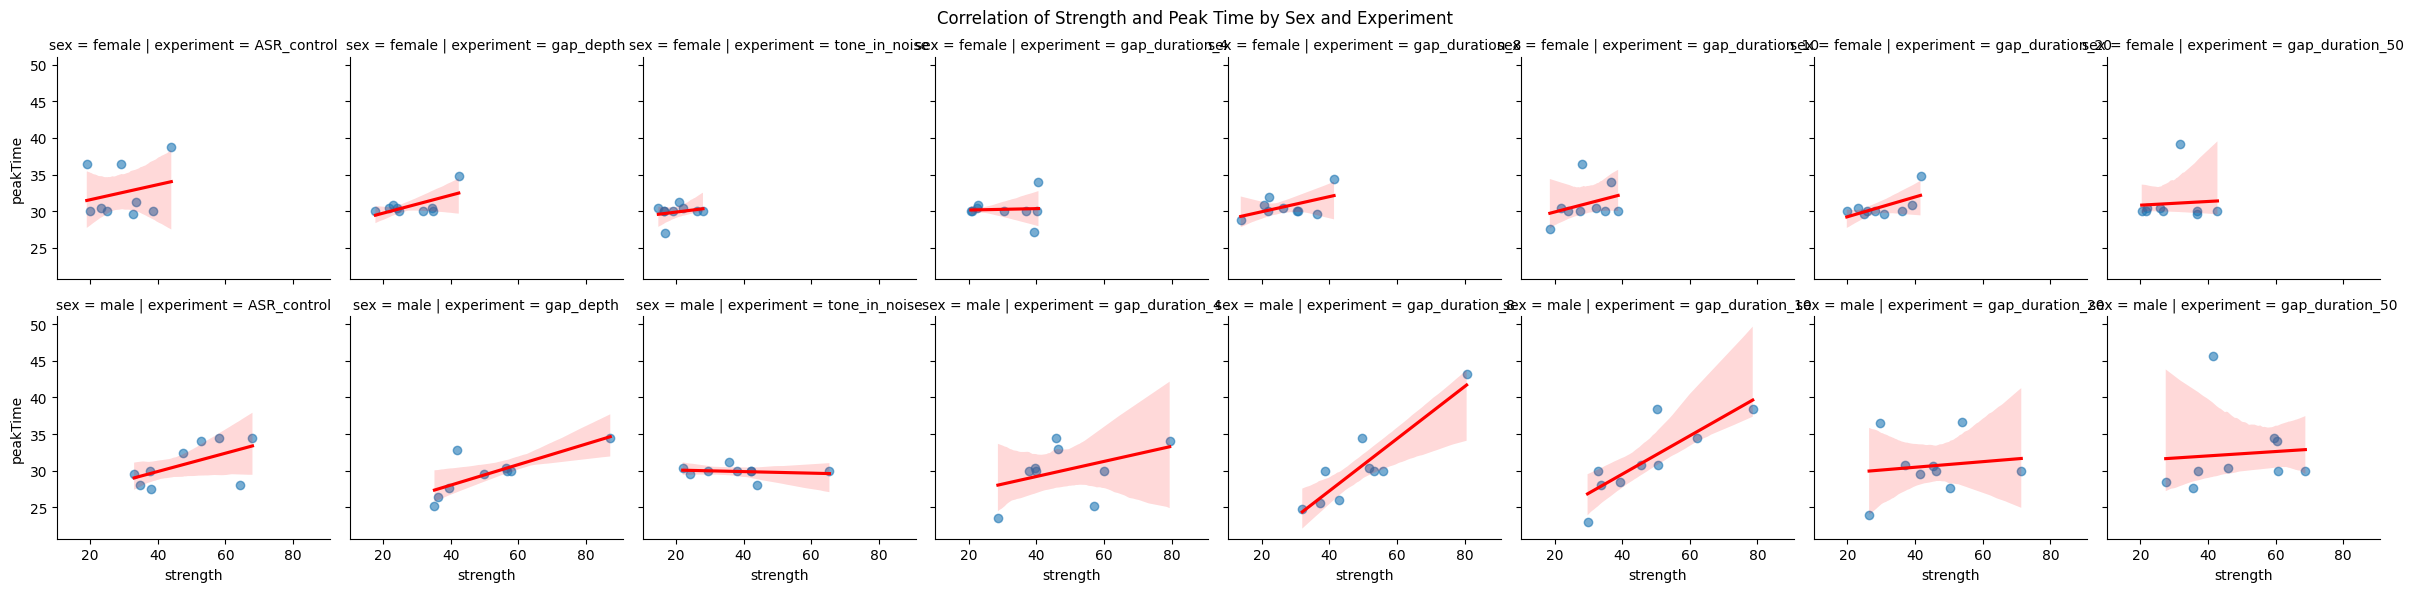

In [127]:
g = sns.lmplot(
    data=df,
    x='strength',
    y='peakTime',
    col='experiment',
    row='sex',
    scatter_kws={'alpha':0.6},
    line_kws={'color': 'red'},
    height=3,
    aspect=1
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Correlation of Strength and Peak Time by Sex and Experiment")
plt.show()


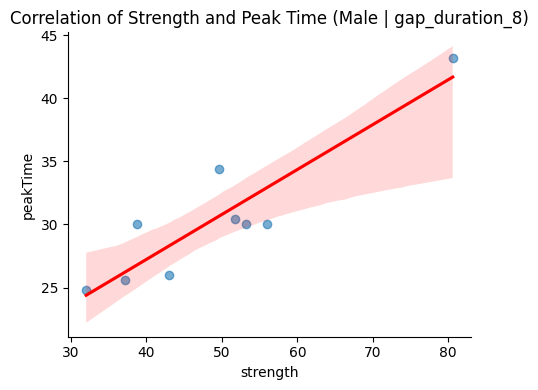

In [128]:
# Filter for the specific group
filtered_df_2 = df[(df['sex'] == 'male') & (df['experiment'] == 'gap_duration_8')]

# Plot
sns.lmplot(
    data=filtered_df_2,
    x='strength',
    y='peakTime',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'},
    height=4,
    aspect=1.2
)

plt.title("Correlation of Strength and Peak Time (Male | gap_duration_8)")
plt.tight_layout()
plt.show()

In [129]:
model = ols("reactionTime ~ experiment", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

              sum_sq     df       F  PR(>F)
experiment   32.2019    7.0  2.9801  0.0061
Residual    209.9356  136.0     NaN     NaN


In [130]:
tukey = pairwise_tukeyhsd(endog=df['reactionTime'],
                        groups=df['experiment'],
                        alpha=0.05)

print(tukey.summary())

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
    ASR_control       gap_depth    -0.65 0.7675  -1.925   0.625  False
    ASR_control gap_duration_10  -0.3778 0.9844 -1.6528  0.8972  False
    ASR_control gap_duration_20  -0.5389  0.897 -1.8139  0.7361  False
    ASR_control  gap_duration_4  -0.3667 0.9869 -1.6417  0.9084  False
    ASR_control gap_duration_50  -0.3278 0.9933 -1.6028  0.9472  False
    ASR_control  gap_duration_8  -0.1944 0.9998 -1.4695  1.0806  False
    ASR_control   tone_in_noise  -1.6667 0.0023 -2.9417 -0.3916   True
      gap_depth gap_duration_10   0.2722 0.9979 -1.0028  1.5472  False
      gap_depth gap_duration_20   0.1111    1.0 -1.1639  1.3861  False
      gap_depth  gap_duration_4   0.2833 0.9973 -0.9917  1.5584  False
      gap_depth gap_duration_50   0.3222  0.994 -0.9528  1.5972  False
      

In [131]:
# Mixed linear model for strength
md = mixedlm("strength ~ sex + experiment", df, groups=df["animal"])
mdf = md.fit()
print(mdf.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       strength 
No. Observations:       144           Method:                   REML     
No. Groups:             6             Scale:                    73.6158  
Min. group size:        24            Log-Likelihood:           -501.6287
Max. group size:        24            Converged:                Yes      
Mean group size:        24.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     29.390    5.528  5.317 0.000  18.555 40.224
sex[T.male]                   18.904    7.346  2.573 0.010   4.506 33.301
experiment[T.gap_depth]        0.908    2.860  0.318 0.751  -4.697  6.514
experiment[T.gap_duration_10] -0.764    2.860 -0.267 0.7

In [132]:
# Step 1: Map gap_duration experiments to one label
def combine_gap_duration(exp):
    if exp.startswith("gap_duration"):
        return "gap_duration"
    else:
        return exp

df['experiment_combined'] = df['experiment'].apply(combine_gap_duration)

# Step 2: Filter out tone_in_noise
df_filtered = df[df['experiment_combined'] != "tone_in_noise"]

# Now run your mixed linear model again with 'experiment_combined' instead of 'experiment'

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

model = mixedlm(
    "reactionTime ~ strength + experiment_combined", 
    df_filtered, 
    groups=df_filtered["animal"]
)
result = model.fit()
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       reactionTime
No. Observations:         126           Method:                   REML        
No. Groups:               6             Scale:                    0.5480      
Min. group size:          21            Log-Likelihood:           -152.2943   
Max. group size:          21            Converged:                Yes         
Mean group size:          21.0                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           12.203    0.399 30.561 0.000 11.420 12.986
experiment_combined[T.gap_depth]    -0.618    0.247 -2.505 0.012 -1.102 -0.134
experiment_combined[T.gap_duration] -0.378    0.191 -1.976 0.048 -0.752 -

In [133]:
def test_animal_effect(df):
    results = []
    significant_groups = []
    non_significant_groups = []

    # Average over dates for same animal & experiment (and sex)
    avg_df = df.groupby(['sex', 'experiment', 'animal']).agg({
        'strength': 'mean',
        'reactionTime': 'mean'
    }).reset_index()

    # Group by sex and experiment
    grouped = avg_df.groupby(['sex', 'experiment'])

    for (sex, exp_type), group in grouped:
        print(f"\nGroup: Sex = {sex}, Experiment Type = {exp_type}")

        animals = group['animal'].unique()
        strength_groups = [group.loc[group['animal'] == animal, 'strength'].values for animal in animals]
        rt_groups = [group.loc[group['animal'] == animal, 'reactionTime'].values for animal in animals]

        # Initialize
        f_stat = float('nan')
        p_strength = 1
        k_stat = float('nan')
        p_reaction = 1

        # Perform tests if more than one animal
        if len(animals) > 1:
            f_stat, p_strength = f_oneway(*strength_groups)
            k_stat, p_reaction = kruskal(*rt_groups)

        # Compute ranges
        strength_range = (group['strength'].min(), group['strength'].max())
        reaction_range = (group['reactionTime'].min(), group['reactionTime'].max())

        # Store full results
        result = {
            'sex': sex,
            'experiment': exp_type,
            'f_stat_strength': round(f_stat, 4) if f_stat == f_stat else None,  # NaN check
            'p_strength': round(p_strength, 4),
            'k_stat_reaction': round(k_stat, 4) if k_stat == k_stat else None,
            'p_reaction': round(p_reaction, 4),
            'strength_range': strength_range,
            'reaction_range': reaction_range,
            'n_animals': len(animals),
            'significant': p_strength < 0.05 or p_reaction < 0.05
        }

        results.append(result)

        if result['significant']:
            significant_groups.append(result)
            print("Significant difference detected for animal in this group!")
            print(f"  Strength p-value: {p_strength:.4f}")
            print(f"  Reaction Time p-value: {p_reaction:.4f}")
        else:
            non_significant_groups.append(result)
            print("No significant difference detected for animal.")
            print(f"  Strength range: {strength_range}")
            print(f"  Reaction Time range: {reaction_range}")

    # Optional: Print summary
    if significant_groups:
        print("\nSummary of groups with significant animal differences:")
        for g in significant_groups:
            print(f"Sex={g['sex']}, Experiment={g['experiment']}:")
            print(f"  Strength p = {g['p_strength']}, Reaction Time p = {g['p_reaction']}")
            print(f"  Strength range: {g['strength_range']}")
            print(f"  Reaction Time range: {g['reaction_range']}")

    return results, significant_groups, non_significant_groups

results, significant, non_significant = test_animal_effect(df)


Group: Sex = female, Experiment Type = ASR_control
No significant difference detected for animal.
  Strength range: (np.float64(22.666666666666668), np.float64(35.86666666666667))
  Reaction Time range: (np.float64(10.0), np.float64(12.566666666666668))

Group: Sex = female, Experiment Type = gap_depth
No significant difference detected for animal.
  Strength range: (np.float64(21.650000000000002), np.float64(33.93333333333333))
  Reaction Time range: (np.float64(9.333333333333334), np.float64(11.566666666666668))

Group: Sex = female, Experiment Type = gap_duration_10
No significant difference detected for animal.
  Strength range: (np.float64(24.733333333333334), np.float64(31.866666666666664))
  Reaction Time range: (np.float64(10.133333333333333), np.float64(10.666666666666666))

Group: Sex = female, Experiment Type = gap_duration_20
No significant difference detected for animal.
  Strength range: (np.float64(24.599999999999998), np.float64(35.13333333333333))
  Reaction Time rang

C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\1962925105.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = df.groupby(['sex', 'experiment', 'animal']).agg({
C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\1962925105.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = avg_df.groupby(['sex', 'experiment'])


In [134]:
alpha = 0.05

# To store p-values
strength_pvals = []
rt_pvals = []

# Group by sex and experiment
grouped = df.groupby(['sex', 'experiment'])

for (sex, experiment), group in grouped:
    print(f"\n--- Group: sex = {sex}, experiment = {experiment} ---")

    # Split by date
    date_groups = list(group.groupby('date'))

    # Only test if more than one date is present
    if len(date_groups) > 1:
        # Strength (assumed normal) → ANOVA
        strength_values = [g['strength'].values for _, g in date_groups]
        f_stat, p_strength = stats.f_oneway(*strength_values)
        strength_pvals.append(p_strength)
        print(f"Strength: ANOVA p = {p_strength:.4f} → {'Significant' if p_strength < alpha else 'Not significant'}")

        # Reaction time (not normal) → Kruskal-Wallis
        rt_values = [g['reactionTime'].values for _, g in date_groups]
        h_stat, p_rt = stats.kruskal(*rt_values)
        rt_pvals.append(p_rt)
        print(f"Reaction time: Kruskal-Wallis p = {p_rt:.4f} → {'Significant' if p_rt < alpha else 'Not significant'}")
    else:
        print("Not enough dates for testing")

# Final summary of p-value ranges
if strength_pvals:
    print(f"\n🧪 Strength ANOVA p-values ranged from {min(strength_pvals):.4f} to {max(strength_pvals):.4f}")
else:
    print("\nNo strength tests performed.")

if rt_pvals:
    print(f"🧪 Reaction time Kruskal–Wallis p-values ranged from {min(rt_pvals):.4f} to {max(rt_pvals):.4f}")
else:
    print("No reaction time tests performed.")


--- Group: sex = female, experiment = ASR_control ---
Strength: ANOVA p = 0.2065 → Not significant
Reaction time: Kruskal-Wallis p = 0.1130 → Not significant

--- Group: sex = female, experiment = gap_depth ---
Strength: ANOVA p = 0.1740 → Not significant
Reaction time: Kruskal-Wallis p = 0.6460 → Not significant

--- Group: sex = female, experiment = gap_duration_10 ---
Strength: ANOVA p = 0.0225 → Significant
Reaction time: Kruskal-Wallis p = 0.0628 → Not significant

--- Group: sex = female, experiment = gap_duration_20 ---
Strength: ANOVA p = 0.0753 → Not significant
Reaction time: Kruskal-Wallis p = 0.3839 → Not significant

--- Group: sex = female, experiment = gap_duration_4 ---
Strength: ANOVA p = 0.0582 → Not significant
Reaction time: Kruskal-Wallis p = 0.1198 → Not significant

--- Group: sex = female, experiment = gap_duration_50 ---
Strength: ANOVA p = 0.0538 → Not significant
Reaction time: Kruskal-Wallis p = 0.4143 → Not significant

--- Group: sex = female, experiment 

C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\2670332694.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['sex', 'experiment'])


In [135]:
for (sex, exp), group in df.groupby(["sex", "experiment"]):
    print(f"\n--- Sex: {sex}, Experiment: {exp} ---")
    
    for var in ["strength", "reactionTime", "peakTime"]:
        data = group[var].dropna()
        if len(data) < 3:
            print(f"{var}: Not enough data")
            continue
        
        stat, p = shapiro(data)
        print(f"{var}: Shapiro-Wilk W = {stat:.3f}, p = {p:.3g}")


--- Sex: female, Experiment: ASR_control ---
strength: Shapiro-Wilk W = 0.955, p = 0.74
reactionTime: Shapiro-Wilk W = 0.902, p = 0.266
peakTime: Shapiro-Wilk W = 0.762, p = 0.00739

--- Sex: female, Experiment: gap_depth ---
strength: Shapiro-Wilk W = 0.937, p = 0.556
reactionTime: Shapiro-Wilk W = 0.958, p = 0.782
peakTime: Shapiro-Wilk W = 0.539, p = 1.84e-05

--- Sex: female, Experiment: gap_duration_10 ---
strength: Shapiro-Wilk W = 0.962, p = 0.818
reactionTime: Shapiro-Wilk W = 0.947, p = 0.658
peakTime: Shapiro-Wilk W = 0.804, p = 0.0224

--- Sex: female, Experiment: gap_duration_20 ---
strength: Shapiro-Wilk W = 0.945, p = 0.639
reactionTime: Shapiro-Wilk W = 0.888, p = 0.189
peakTime: Shapiro-Wilk W = 0.596, p = 8.64e-05

--- Sex: female, Experiment: gap_duration_4 ---
strength: Shapiro-Wilk W = 0.818, p = 0.0324
reactionTime: Shapiro-Wilk W = 0.879, p = 0.153
peakTime: Shapiro-Wilk W = 0.785, p = 0.0139

--- Sex: female, Experiment: gap_duration_50 ---
strength: Shapiro-Wil

C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\3475152899.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, exp), group in df.groupby(["sex", "experiment"]):



reactionTime distribution fit parameters and KS test:
Lognormal params: (np.float64(0.1413046244398367), 0, np.float64(10.235404238298162))
Gamma params: (54.99736445192515, 0, np.float64(0.1878120300781995))
Weibull params: (np.float64(8.508034691836777), 0, np.float64(10.861320089922469))
KS test results:
 Lognormal: D = 0.2749, p = 0.0000
 Gamma:     D = 0.2634, p = 0.0000
 Weibull:   D = 0.2308, p = 0.0000


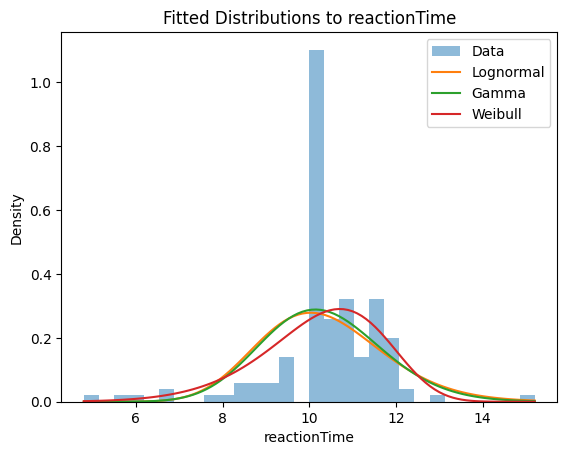


strength distribution fit parameters and KS test:
Lognormal params: (np.float64(0.3892828672266268), 0, np.float64(34.720463076614415))
Gamma params: (6.787825610079539, 0, np.float64(5.516064419470934))
Weibull params: (np.float64(2.663917236735819), 0, np.float64(42.18547266957767))
KS test results:
 Lognormal: D = 0.0512, p = 0.8255
 Gamma:     D = 0.0480, p = 0.8780
 Weibull:   D = 0.0853, p = 0.2325


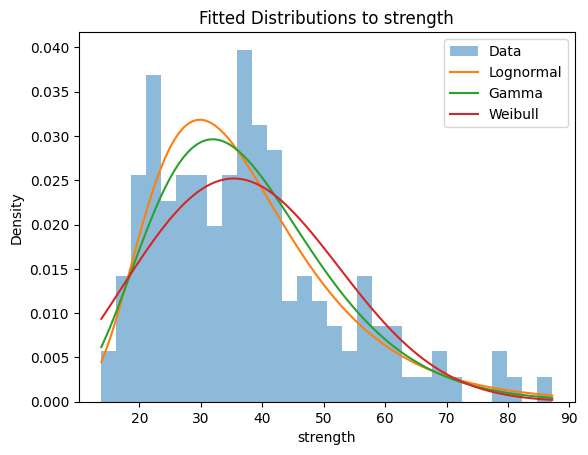


peakTime distribution fit parameters and KS test:
Lognormal params: (np.float64(0.09997180068362962), 0, np.float64(30.595078079597155))
Gamma params: (97.67738425744989, 0, np.float64(0.31483604259975484))
Weibull params: (np.float64(7.991362748088024), 0, np.float64(32.27443009231699))
KS test results:
 Lognormal: D = 0.2442, p = 0.0000
 Gamma:     D = 0.2513, p = 0.0000
 Weibull:   D = 0.2733, p = 0.0000


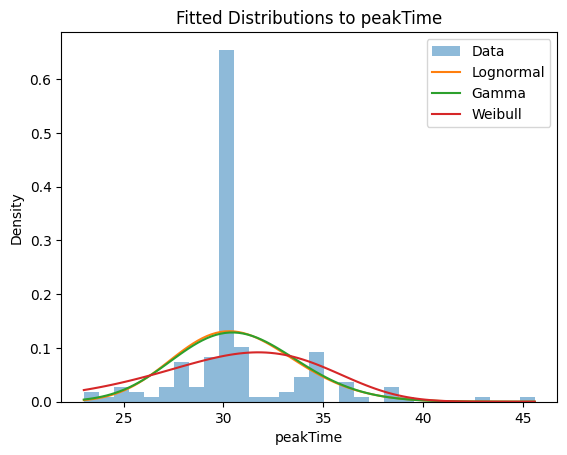

In [136]:
def fit_and_plot(data, var_name):
    data = data.dropna()
    if len(data) < 10:
        print(f"Not enough data for {var_name}")
        return
    
    # Fit distributions (fix loc=0 for these to simplify)
    params_lognorm = lognorm.fit(data, floc=0)
    params_gamma = gamma.fit(data, floc=0)
    params_weibull = weibull_min.fit(data, floc=0)

    # KS test for goodness of fit
    ks_lognorm = kstest(data, 'lognorm', args=params_lognorm)
    ks_gamma = kstest(data, 'gamma', args=params_gamma)
    ks_weibull = kstest(data, 'weibull_min', args=params_weibull)

    print(f"\n{var_name} distribution fit parameters and KS test:")
    print(f"Lognormal params: {params_lognorm}")
    print(f"Gamma params: {params_gamma}")
    print(f"Weibull params: {params_weibull}")
    print(f"KS test results:")
    print(f" Lognormal: D = {ks_lognorm.statistic:.4f}, p = {ks_lognorm.pvalue:.4f}")
    print(f" Gamma:     D = {ks_gamma.statistic:.4f}, p = {ks_gamma.pvalue:.4f}")
    print(f" Weibull:   D = {ks_weibull.statistic:.4f}, p = {ks_weibull.pvalue:.4f}")

    # Plot histogram and fitted PDFs
    x = np.linspace(min(data), max(data), 100)
    plt.hist(data, bins=30, density=True, alpha=0.5, label='Data')
    plt.plot(x, lognorm.pdf(x, *params_lognorm), label='Lognormal')
    plt.plot(x, gamma.pdf(x, *params_gamma), label='Gamma')
    plt.plot(x, weibull_min.pdf(x, *params_weibull), label='Weibull')

    plt.legend()
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title(f'Fitted Distributions to {var_name}')
    plt.show()

# Run on reactionTime and strength
fit_and_plot(df['reactionTime'], 'reactionTime')
fit_and_plot(df['strength'], 'strength')
fit_and_plot(df['peakTime'], 'peakTime')

In [137]:

def ks_fits(data):
    results = {}
    
    # Log-normal
    shape, loc, scale = lognorm.fit(data)
    p_ln = kstest(data, 'lognorm', args=(shape, loc, scale)).pvalue
    results["lognorm"] = p_ln

    # Gamma
    a, loc, scale = gamma.fit(data)
    p_gamma = kstest(data, 'gamma', args=(a, loc, scale)).pvalue
    results["gamma"] = p_gamma

    # Weibull
    c, loc, scale = weibull_min.fit(data)
    p_weibull = kstest(data, 'weibull_min', args=(c, loc, scale)).pvalue
    results["weibull"] = p_weibull

    return results

# Loop over groups
for (sex, exp), group in df.groupby(["sex", "experiment"]):
    print(f"\n--- Sex: {sex}, Experiment: {exp} ---")
    
    for var in ["strength", "reactionTime"]:
        data = group[var].dropna()
        if len(data) < 3:
            print(f"{var}: Not enough data")
            continue

        # Shapiro-Wilk
        stat, p = shapiro(data)
        print(f"{var}: Shapiro-Wilk W = {stat:.3f}, p = {p:.3g}")

        # KS fits
        ks_results = ks_fits(data)
        for dist, p_ks in ks_results.items():
            print(f"  KS {dist}: p = {p_ks:.3g}")


--- Sex: female, Experiment: ASR_control ---
strength: Shapiro-Wilk W = 0.955, p = 0.74
  KS lognorm: p = 0.0331
  KS gamma: p = 0.413
  KS weibull: p = 0.613
reactionTime: Shapiro-Wilk W = 0.902, p = 0.266
  KS lognorm: p = 0.0278
  KS gamma: p = 0.00773
  KS weibull: p = 0.195

--- Sex: female, Experiment: gap_depth ---
strength: Shapiro-Wilk W = 0.937, p = 0.556


C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\3096941879.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, exp), group in df.groupby(["sex", "experiment"]):


  KS lognorm: p = 0.0142
  KS gamma: p = 0.908
  KS weibull: p = 0.924
reactionTime: Shapiro-Wilk W = 0.958, p = 0.782
  KS lognorm: p = 0.023
  KS gamma: p = 0.925
  KS weibull: p = 0.991

--- Sex: female, Experiment: gap_duration_10 ---
strength: Shapiro-Wilk W = 0.962, p = 0.818
  KS lognorm: p = 0.0171
  KS gamma: p = 0.987
  KS weibull: p = 0.986
reactionTime: Shapiro-Wilk W = 0.947, p = 0.658
  KS lognorm: p = 0.0173
  KS gamma: p = 0.927
  KS weibull: p = 0.97

--- Sex: female, Experiment: gap_duration_20 ---
strength: Shapiro-Wilk W = 0.945, p = 0.639
  KS lognorm: p = 0.0162
  KS gamma: p = 0.972
  KS weibull: p = 0.968
reactionTime: Shapiro-Wilk W = 0.888, p = 0.189
  KS lognorm: p = 0.00907
  KS gamma: p = 0.488
  KS weibull: p = 0.791

--- Sex: female, Experiment: gap_duration_4 ---
strength: Shapiro-Wilk W = 0.818, p = 0.0324
  KS lognorm: p = 0.0488
  KS gamma: p = 0.45
  KS weibull: p = 0.387
reactionTime: Shapiro-Wilk W = 0.879, p = 0.153
  KS lognorm: p = 0.0681
  KS g

In [138]:
def analyze_distribution(data, label):
    data = data.dropna()
    print(f"\n--- {label} ---")

    # 1. Shapiro-Wilk normality test
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk: W = {stat:.3f}, p = {p:.3g}")

    # 2. Histogram and KDE
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(data, kde=True, bins=30)
    plt.title(f'{label} Histogram + KDE')

    # 3. Q-Q plot
    plt.subplot(1, 3, 2)
    probplot(data, dist="norm", plot=plt)
    plt.title(f'{label} Q-Q Plot')

    # 4. Fit alternative distributions
    plt.subplot(1, 3, 3)
    sns.histplot(data, stat='density', bins=30, color='lightgray', label='Data')

    x = np.linspace(min(data), max(data), 1000)

    # Log-normal
    shape, loc, scale = lognorm.fit(data)
    plt.plot(x, lognorm.pdf(x, shape, loc=loc, scale=scale), label='Log-normal')
    ks_lognorm = kstest(data, 'lognorm', args=(shape, loc, scale)).pvalue

    # Gamma
    a, loc, scale = gamma.fit(data)
    plt.plot(x, gamma.pdf(x, a, loc=loc, scale=scale), label='Gamma')
    ks_gamma = kstest(data, 'gamma', args=(a, loc, scale)).pvalue

    # Weibull
    c, loc, scale = weibull_min.fit(data)
    plt.plot(x, weibull_min.pdf(x, c, loc=loc, scale=scale), label='Weibull')
    ks_weibull = kstest(data, 'weibull_min', args=(c, loc, scale)).pvalue

    plt.title(f'{label} Distribution Fits')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"KS p-values:")
    print(f"  Log-normal: {ks_lognorm:.3g}")
    print(f"  Gamma:      {ks_gamma:.3g}")
    print(f"  Weibull:    {ks_weibull:.3g}")


--- Strength ---
Shapiro-Wilk: W = 0.940, p = 7.34e-06


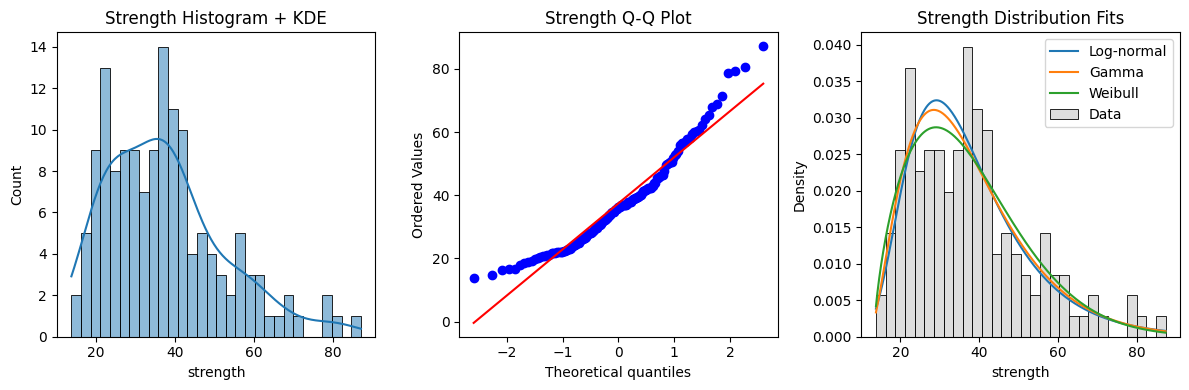

KS p-values:
  Log-normal: 0.687
  Gamma:      0.754
  Weibull:    0.902

--- Reaction Time ---
Shapiro-Wilk: W = 0.872, p = 8.26e-10


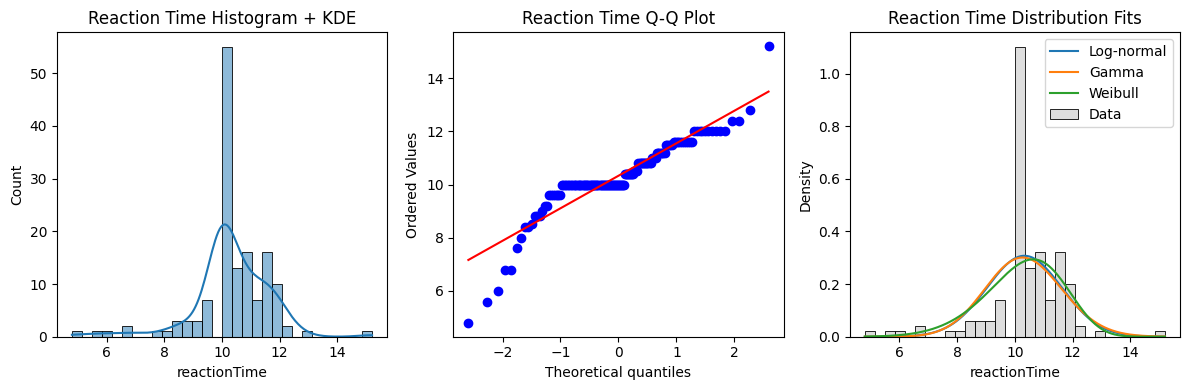

KS p-values:
  Log-normal: 8.65e-08
  Gamma:      3.5e-08
  Weibull:    2.45e-07


In [139]:
analyze_distribution(df["strength"], "Strength")
analyze_distribution(df["reactionTime"], "Reaction Time")

Strength: W = 0.940, p = 7.34e-06
Reaction Time: W = 0.872, p = 8.26e-10
Log-transformed Reaction Time: p = 4.24e-13
Log-transformed Strength: W = 0.991, p = 0.494
Box-Cox Transformed Reaction Time: W = 0.898, p = 1.72e-08
Box-Cox Transformed Strength: W = 0.991, p = 0.495
Optimal λ = 2.098


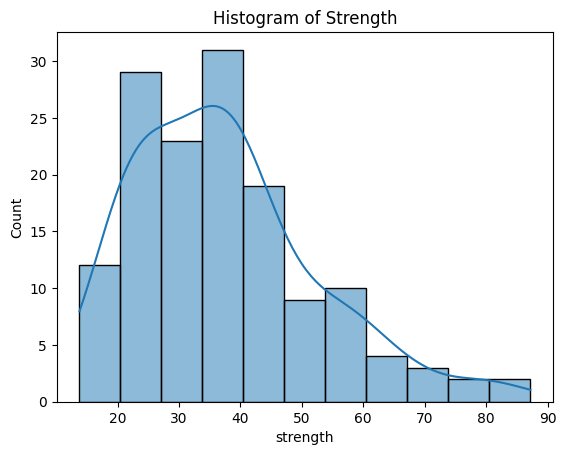

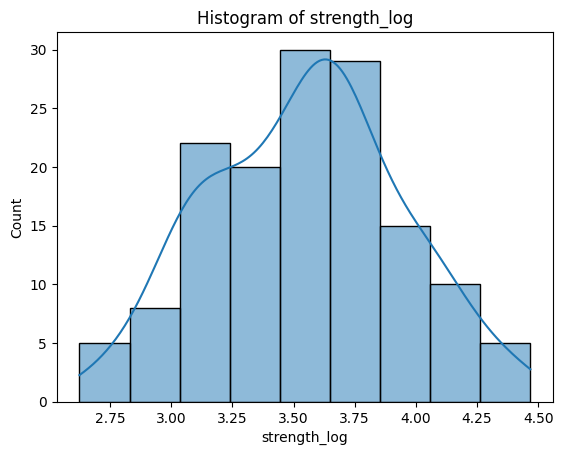

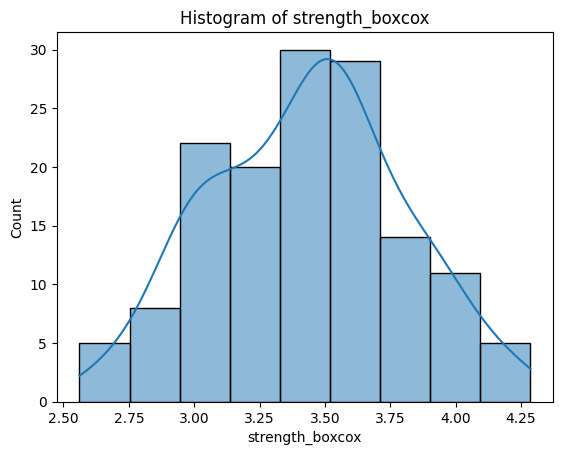

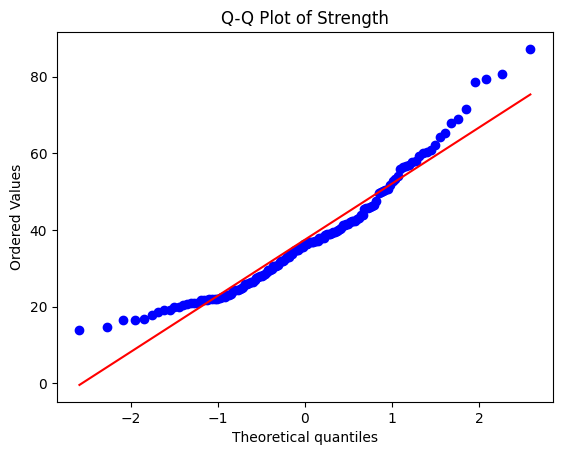

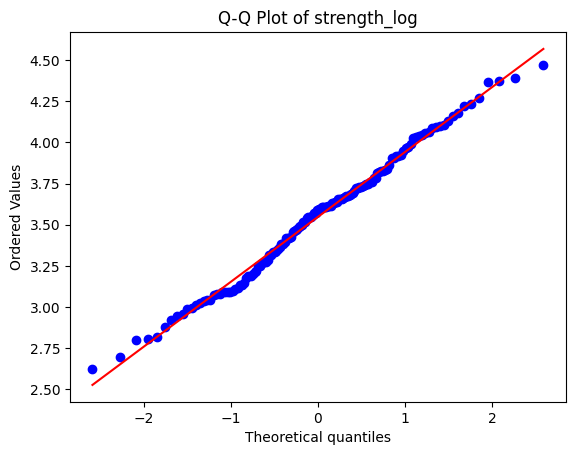

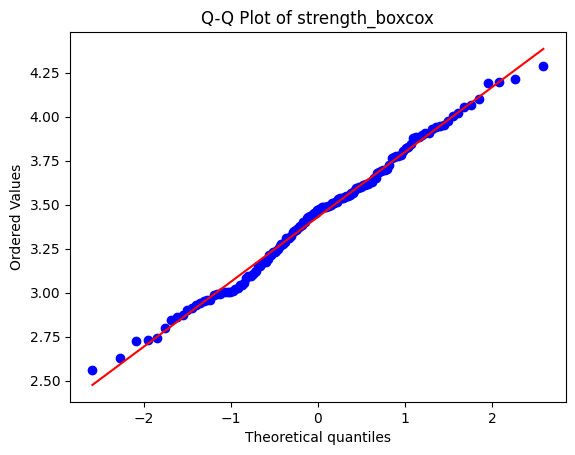

In [140]:
# Shapiro-Wilk test for normality

stat_strength, p_strength = shapiro(df["strength"].dropna())
print(f"Strength: W = {stat_strength:.3f}, p = {p_strength:.3g}")

# Run Shapiro–Wilk test for reaction time
stat_rt, p_rt = shapiro(df["reactionTime"].dropna())
print(f"Reaction Time: W = {stat_rt:.3f}, p = {p_rt:.3g}")

# Try log fit
df["reactionTime_log"] = np.log(df["reactionTime"])
stat_rt_log, p_rt_log = shapiro(df["reactionTime_log"].dropna())
print(f"Log-transformed Reaction Time: p = {p_rt_log:.3g}")
# ----> nope

df["strength_log"] = np.log(df["strength"])
stat_strength_log, p_strength_log = shapiro(df["strength_log"].dropna())
print(f"Log-transformed Strength: W = {stat_strength_log:.3f}, p = {p_strength_log:.3g}")
# ----> normal

reaction_times = df["reactionTime"].dropna()

# Try Box-Cox transform
reaction_time_boxcox, fitted_lambda = boxcox(reaction_times)
strength_boxcox, fitted_lambda_strength = boxcox(df["strength"].dropna())

# Store transformed values in the DataFrame (optional)
df["reactionTime_boxcox"] = pd.Series(reaction_time_boxcox, index=reaction_times.index)
df["strength_boxcox"] = pd.Series(strength_boxcox, index=df["strength"].dropna().index)

# Test normality of Box-Cox transformed data
stat_boxcox, p_boxcox = shapiro(reaction_time_boxcox)
print(f"Box-Cox Transformed Reaction Time: W = {stat_boxcox:.3f}, p = {p_boxcox:.3g}")
# ----> nope

stat_strength_boxcox, p_strength_boxcox = shapiro(strength_boxcox)
print(f"Box-Cox Transformed Strength: W = {stat_strength_boxcox:.3f}, p = {p_strength_boxcox:.3g}")
# ----> normal
print(f"Optimal λ = {fitted_lambda:.3f}")

# -> reaction time non-parametric, strength normally distributed if fitted

# plot
sns.histplot(df["strength"].dropna(), kde=True)
plt.title("Histogram of Strength")
plt.show()

# plot
sns.histplot(df["strength_log"].dropna(), kde=True)
plt.title("Histogram of strength_log")
plt.show()

# plot
sns.histplot(df["strength_boxcox"].dropna(), kde=True)
plt.title("Histogram of strength_boxcox")
plt.show()

# Q-Q Plot
stats.probplot(df["strength"].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Strength")
plt.show()

# Q-Q Plot
stats.probplot(df["strength_log"].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of strength_log")
plt.show()

# Q-Q Plot
stats.probplot(df["strength_boxcox"].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of strength_boxcox")
plt.show()

In [141]:
# Group by experiment
for exp_name, df_exp in df.groupby('experiment'):

    print(f"\n=== Experiment: {exp_name} ===")

    # --- Reaction Time (non-parametric) ---
    rt_groups = [group['reactionTime'].values for _, group in df_exp.groupby('animal')]
    if len(rt_groups) > 1:
        h_stat, p_val = kruskal(*rt_groups)
        print(f"Kruskal-Wallis (reaction time): H = {h_stat:.3f}, p = {p_val:.3g}")
    else:
        print("Not enough animals for reaction time test.")

    # --- Strength (parametric), by sex ---
    for sex in ['male', 'female']:
        df_sex = df_exp[df_exp['sex'] == sex]
        if df_sex['animal'].nunique() > 1:
            model = ols("strength ~ C(animal)", data=df_sex).fit()
            anova_result = sm.stats.anova_lm(model, typ=2)
            print(f"\nANOVA for strength among {sex} animals:")
            print(anova_result)
        else:
            print(f"\nNot enough {sex} animals for strength ANOVA.")


=== Experiment: ASR_control ===
Kruskal-Wallis (reaction time): H = 5.490, p = 0.359

ANOVA for strength among male animals:
             sum_sq   df       F  PR(>F)
C(animal)  824.6739  2.0  4.3784  0.0672
Residual   565.0550  6.0     NaN     NaN

ANOVA for strength among female animals:
             sum_sq   df       F  PR(>F)
C(animal)  261.9289  2.0  2.4694   0.165
Residual   318.2133  6.0     NaN     NaN

=== Experiment: gap_depth ===
Kruskal-Wallis (reaction time): H = 8.394, p = 0.136

ANOVA for strength among male animals:
              sum_sq   df       F  PR(>F)
C(animal)  1135.4539  2.0  3.5463  0.0962
Residual    960.5283  6.0     NaN     NaN

ANOVA for strength among female animals:
             sum_sq   df       F  PR(>F)
C(animal)  231.0739  2.0  2.5525  0.1577
Residual   271.5883  6.0     NaN     NaN

=== Experiment: gap_duration_10 ===
Kruskal-Wallis (reaction time): H = 3.730, p = 0.589

ANOVA for strength among male animals:
              sum_sq   df       F  PR(>F)

In [142]:
# compare top 10

if df_top_10:
    t_stat, p_val = ttest_ind(df_top_10["strength"].dropna(),
                            df["strength"].dropna(),
                            equal_var=False)  # Welch’s t-test if variances unequal
    print(f"T-test for strength: t = {t_stat:.3f}, p = {p_val:.3g}")
    # ----> nope


    u_stat, p_val = mannwhitneyu(df_top_10["reactionTime"].dropna(),
                                df["reactionTime"].dropna(),
                                alternative='two-sided')
    print(f"Mann-Whitney U test for reaction time: U = {u_stat}, p = {p_val:.3g}")
    # ----> nope

In [143]:
# 2. Relationship between sex and strength (independent two-group t-test and ANCOVA with weight as covariate)

# Independent t-test (assumes 'sex' coded as categorical, e.g., 'M', 'F')
group1 = df[df["sex"] == "M"]["strength"].dropna()
group2 = df[df["sex"] == "F"]["strength"].dropna()

t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(f"T-test for strength by sex: t = {t_stat:.3f}, p = {p_val:.3g}")
# --> sample size too small 
""" 
# ANCOVA: strength ~ sex + weight
# Make sure sex is treated as categorical
df['sex'] = df['sex'].astype('category')

model = ols("Q('strength (g⋅kg^(-α))') ~ sex + weight", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANCOVA table:\n", anova_table)
# --> effect of both weight and sex on strength  """

T-test for strength by sex: t = nan, p = nan


C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\837830791.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(group1, group2, equal_var=False)


' \n# ANCOVA: strength ~ sex + weight\n# Make sure sex is treated as categorical\ndf[\'sex\'] = df[\'sex\'].astype(\'category\')\n\nmodel = ols("Q(\'strength (g⋅kg^(-α))\') ~ sex + weight", data=df).fit()\nanova_table = sm.stats.anova_lm(model, typ=2)\nprint("ANCOVA table:\n", anova_table)\n# --> effect of both weight and sex on strength  '

In [144]:
#3. Influence of sex on reaction time (non-normal data → Mann–Whitney U test)

group1_rt = df[df["sex"] == "M"]["reactionTime"].dropna()
group2_rt = df[df["sex"] == "F"]["reactionTime"].dropna()

u_stat, p_val = mannwhitneyu(group1_rt, group2_rt, alternative='two-sided')
print(f"Mann-Whitney U test for reaction time by sex: U = {u_stat}, p = {p_val:.3g}")
# --> sample size too small 

Mann-Whitney U test for reaction time by sex: U = nan, p = nan


C:\Users\Galahad\AppData\Local\Temp\ipykernel_18840\3497997993.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_val = mannwhitneyu(group1_rt, group2_rt, alternative='two-sided')


In [145]:
# Check for male/female differences in reaction time
results = []

# Group by experiment
for exp_name, group in df.groupby("experiment"):
    males = group[group['sex'] == 'male']['reactionTime']
    females = group[group['sex'] == 'female']['reactionTime']
    
    # Only run test if both groups have data
    if len(males) > 0 and len(females) > 0:
        stat, p = mannwhitneyu(males, females, alternative='two-sided')
        results.append({
            "experiment": exp_name,
            "U_statistic": stat,
            "p_value": p,
            "male_n": len(males),
            "female_n": len(females)
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Show results
print(results_df.sort_values("p_value"))

        experiment  U_statistic  p_value  male_n  female_n
4   gap_duration_4         23.0   0.1082       9         9
5  gap_duration_50         29.0   0.2986       9         9
1        gap_depth         29.0   0.3162       9         9
3  gap_duration_20         30.5   0.3859       9         9
7    tone_in_noise         30.5   0.4011       9         9
0      ASR_control         34.0   0.5882       9         9
2  gap_duration_10         40.5   1.0000       9         9
6   gap_duration_8         40.0   1.0000       9         9


In [146]:
# 4. Relationship between day of measurement and strength (normal) and reaction time (non-normal) (NEEDS THIRD RECORDING)


# ANOVA for strength by day

strength_agg = df.groupby(['animal', 'date'])["strength"].mean().reset_index()
strength_agg['date'] = strength_agg['date'].astype('category')

model_strength = ols("Q('strength') ~ date", data=strength_agg).fit()
anova_strength = sm.stats.anova_lm(model_strength, typ=2)
print("ANOVA for strength by date:\n", anova_strength)
# ----> no change of strength across days

# Friedman test for reaction time by day (non-parametric)

# Aggregate reaction time per animal per date (e.g., mean)
reaction_time_agg = df.groupby(['animal', 'date'])['reactionTime'].mean().reset_index()

# Pivot to wide format for Friedman test
reaction_time_wide = reaction_time_agg.pivot(index='animal', columns='date', values='reactionTime').dropna()

# Run Friedman test (needs 3rd recording)
stat, p_val = friedmanchisquare(*[reaction_time_wide[day] for day in reaction_time_wide.columns])
print(f"Friedman test for reaction time by date: chi2 = {stat:.3f}, p = {p_val:.3g}")
# ----> needs third recording day to work


#Linear Mixed Model (more advanced, handles repeated measures)

# For strength (normal)
model_lmm_strength = smf.mixedlm("Q('strength') ~ date", df, groups=df["animal"]).fit()
#print(model_lmm_strength.summary())

ANOVA for strength by date:
              sum_sq    df       F  PR(>F)
date       454.1271   2.0  1.1245  0.3507
Residual  3028.9053  15.0     NaN     NaN
Friedman test for reaction time by date: chi2 = 1.000, p = 0.607


In [147]:
# 5 Experiment type

model_lmm_strength = smf.mixedlm("Q('strength') ~ experiment", df, groups=df["animal"]).fit()
print(model_lmm_strength.summary())

model_lmm_rt = smf.mixedlm("Q('reactionTime') ~ experiment", df, groups=df["animal"]).fit()
print(model_lmm_rt.summary())
# ----> no effect on strength, some effect on reaction time
# highly significant difference for tone_in_noise
# meaningful difference in reaction time between individuals


print("Strength experiment type effects:")
print(model_lmm_strength.summary())

print("\nReaction Time experiment type effects:")
print(model_lmm_rt.summary())

# You can extract p-values like:
print("\nP-values for experiment effects on strength:")
print(model_lmm_strength.pvalues)

print("\nP-values for experiment effects on reaction time:")
print(model_lmm_rt.pvalues)

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Q('strength')
No. Observations:      144          Method:                  REML         
No. Groups:            6            Scale:                   73.6156      
Min. group size:       24           Log-Likelihood:          -506.9252    
Max. group size:       24           Converged:               Yes          
Mean group size:       24.0                                               
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      38.842    5.678  6.841 0.000  27.714 49.970
experiment[T.gap_depth]         0.908    2.860  0.318 0.751  -4.697  6.514
experiment[T.gap_duration_10]  -0.764    2.860 -0.267 0.789  -6.369  4.842
experiment[T.gap_duration_20]  -1.579    2.8

In [148]:
formula = 'Q("strength") ~ sex'

model = smf.ols(formula=formula, data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("strength")   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     96.55
Date:                Sat, 05 Jul 2025   Prob (F-statistic):           1.05e-17
Time:                        16:19:17   Log-Likelihood:                -555.56
No. Observations:                 144   AIC:                             1115.
Df Residuals:                     142   BIC:                             1121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      27.9903      1.360     20.575      

# Plotting

In [149]:
def analyze_results(df=df, strength=False, by_date=False, by_sex=True):
    if not by_date:
        if by_sex:
            grouped_df = df.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()
        else:
            grouped_df = df.groupby(['experiment'], as_index=False, observed=True)['strength'].mean() if strength else df.groupby(['experiment'], as_index=False, observed=True)['reactionTime'].mean()
        
    else:
        grouped_df = {}
        unique_dates = df['date'].unique()

        for date in unique_dates: 
            df_date = df[df['date'] == date]
            if by_sex:
                grouped_df[date] = df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()
            else:
                grouped_df[date] = df_date.groupby(['experiment'], as_index=False, observed=True)['strength'].mean() if strength else df_date.groupby(['experiment'], as_index=False, observed=True)['reactionTime'].mean()

    print(grouped_df)

In [150]:
def plot_results(df=df, strength=False, by_date=False):
    if not by_date:
        # Group by experiment and sex, averaging reactionTime across animals and dates
        grouped_df = df.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()

        # Preserve the order of experiments
        experiment_order = df['experiment'].drop_duplicates().tolist()
        grouped_df['experiment'] = pd.Categorical(grouped_df['experiment'], categories=experiment_order, ordered=True)

        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=grouped_df,
            x='experiment',
            y='strength' if strength else 'reactionTime',
            hue='sex',
            order=experiment_order,
            errorbar=None
        )

        #plt.xticks(rotation=45, ha='right')
        plt.title("Average Strength per Experiment") if strength else plt.title("Average Reaction Time per Experiment")
        plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
        plt.xlabel("Experiment")
        plt.tight_layout()
        plt.show()
        
    else:
        experiment_order = df['experiment'].drop_duplicates().tolist()

        unique_dates = df['date'].unique()

        for date in unique_dates:
            df_date = df[df['date'] == date]

            grouped = df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()

            grouped['experiment'] = pd.Categorical(grouped['experiment'], categories=experiment_order, ordered=True)

            plt.figure(figsize=(12, 6))
            sns.barplot(
                data=grouped,
                x='experiment',
                y='strength' if strength else 'reactionTime',
                hue='sex',
                order=experiment_order,
                errorbar=None
            )

            plt.title(f"Average Strength per Experiment - {date}") if strength else plt.title(f"Average Reaction Time per Experiment - {date}")
            #plt.xticks(rotation=45, ha='right')
            plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
            plt.xlabel("Experiment")
            plt.tight_layout()
            plt.show()

In [151]:
analyze_results()

         experiment     sex  reactionTime
0       ASR_control  female       11.0778
1       ASR_control    male       10.6111
2         gap_depth  female       10.3444
3         gap_depth    male       10.0444
4   gap_duration_10  female       10.4778
5   gap_duration_10    male       10.4556
6   gap_duration_20  female       10.3778
7   gap_duration_20    male       10.2333
8    gap_duration_4  female       10.6889
9    gap_duration_4    male       10.2667
10  gap_duration_50  female       10.7556
11  gap_duration_50    male       10.2778
12   gap_duration_8  female       10.6778
13   gap_duration_8    male       10.6222
14    tone_in_noise  female        9.5444
15    tone_in_noise    male        8.8111


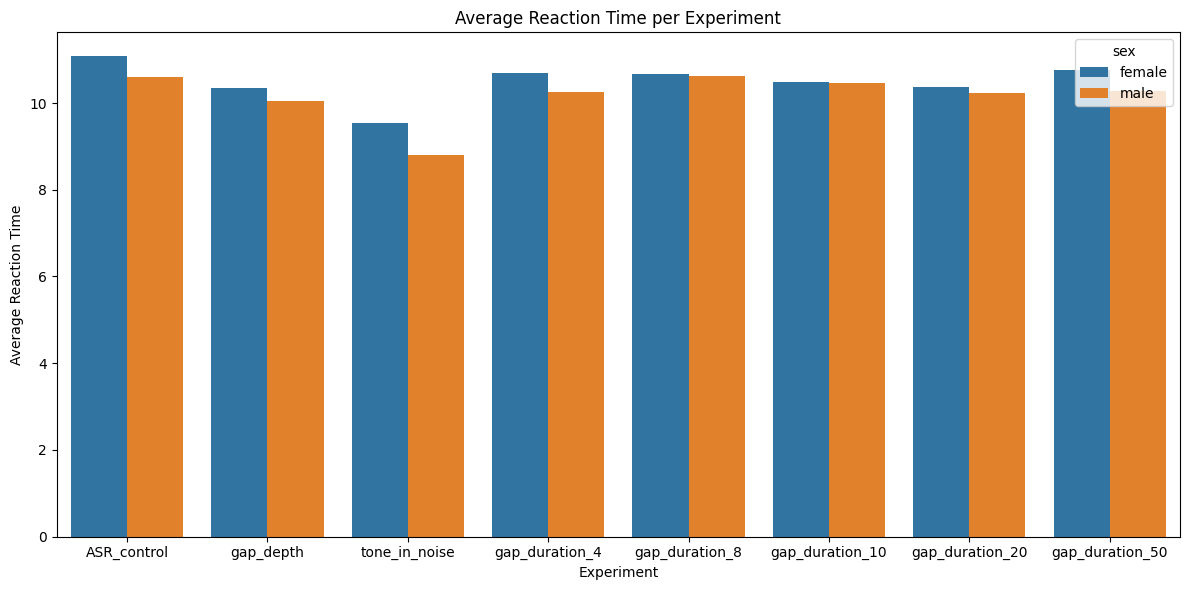

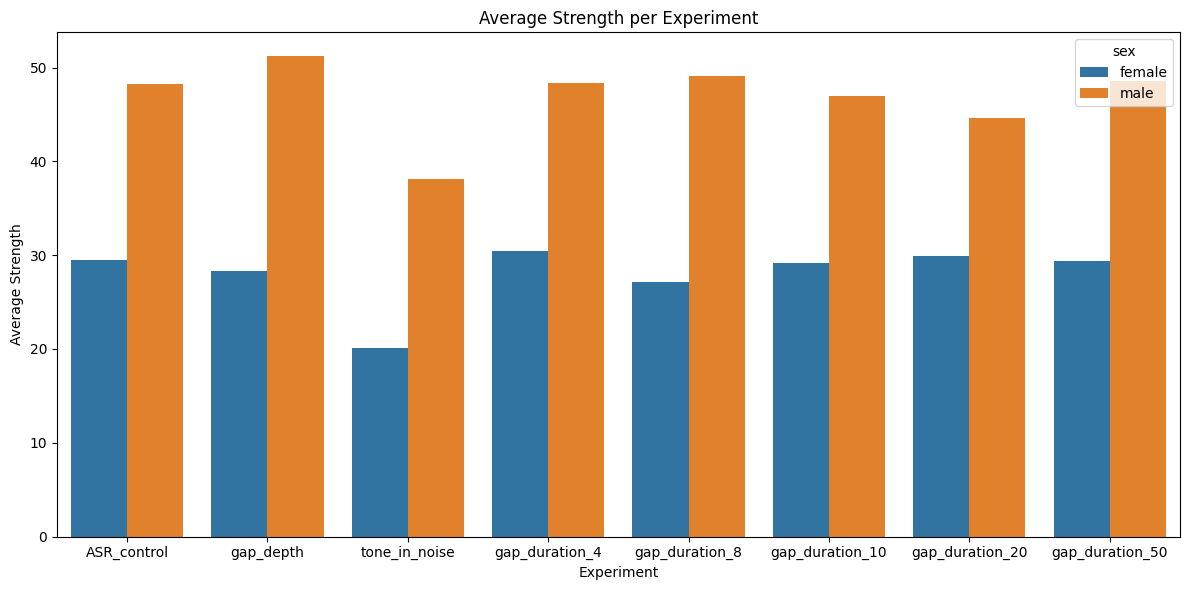

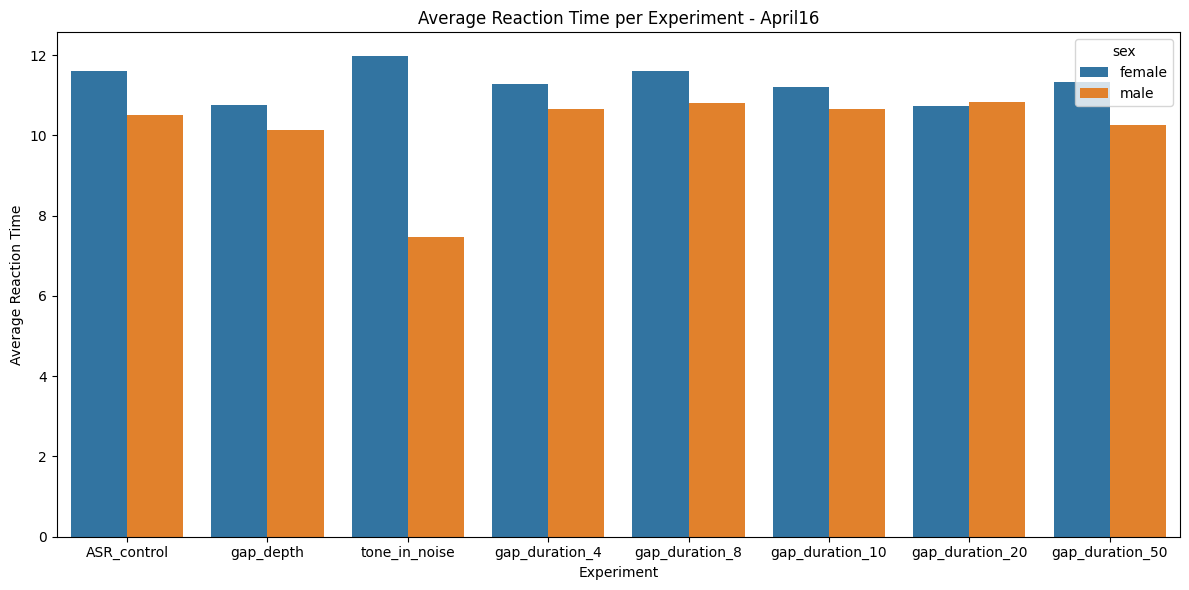

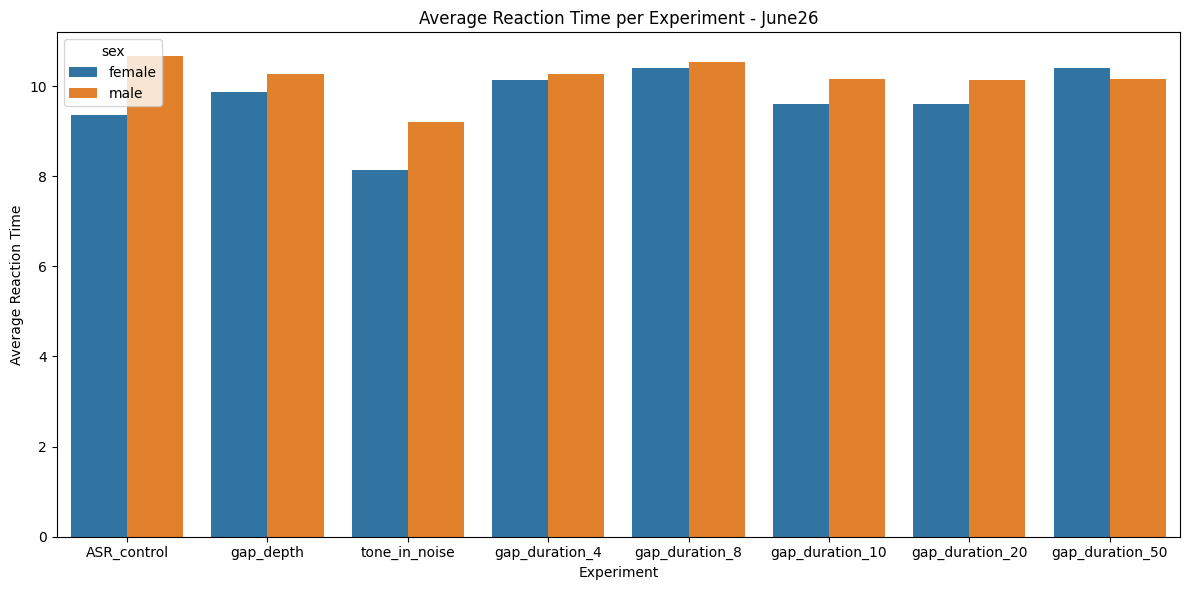

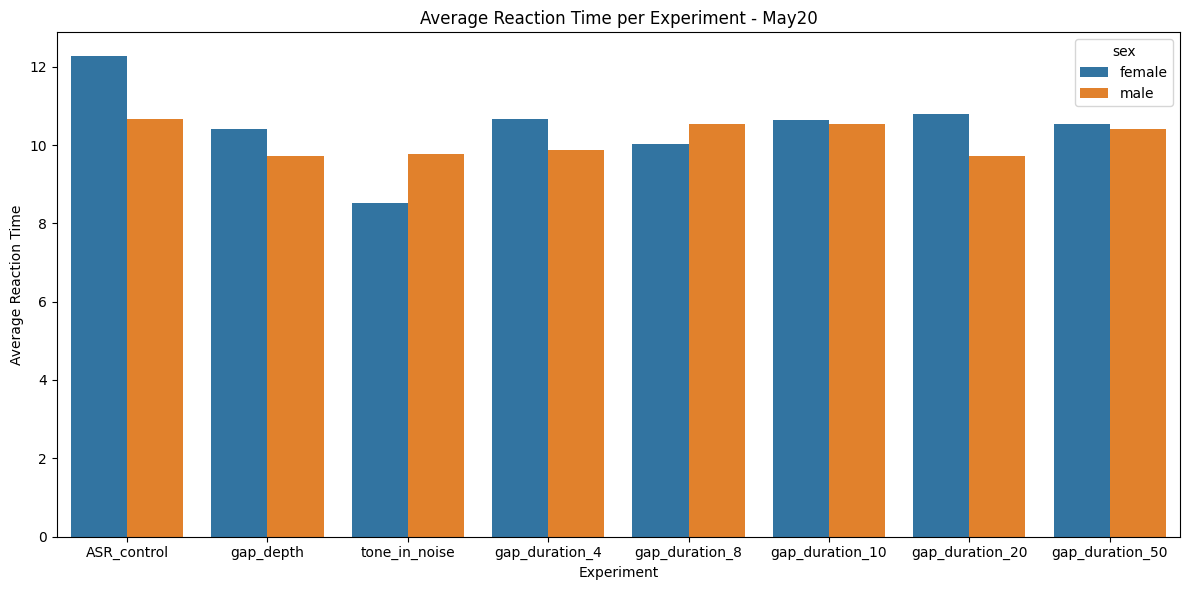

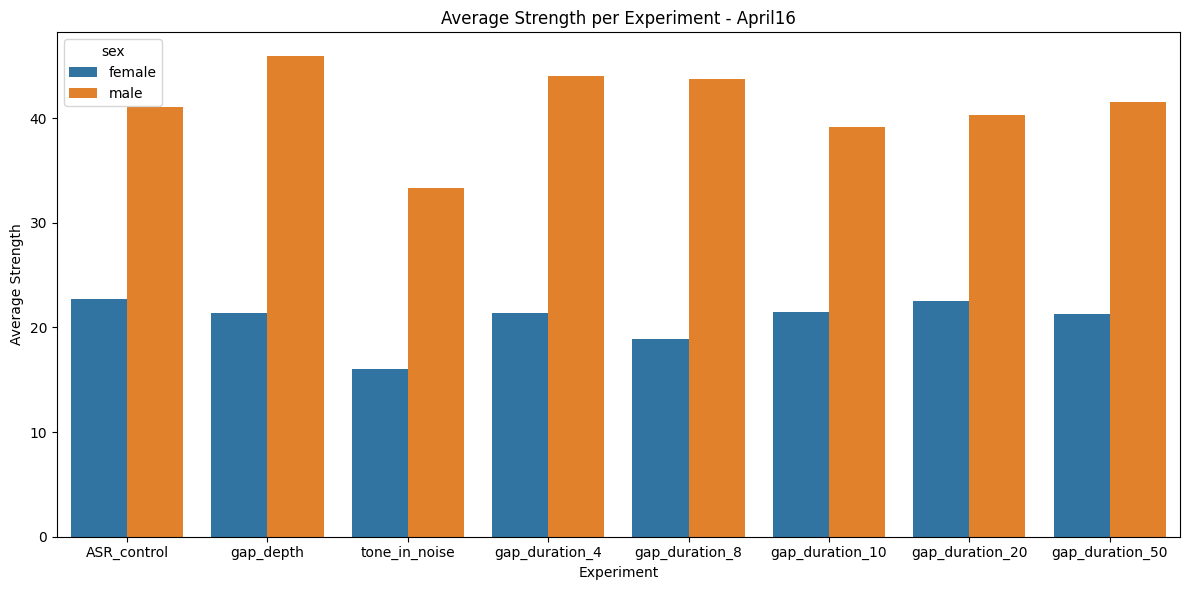

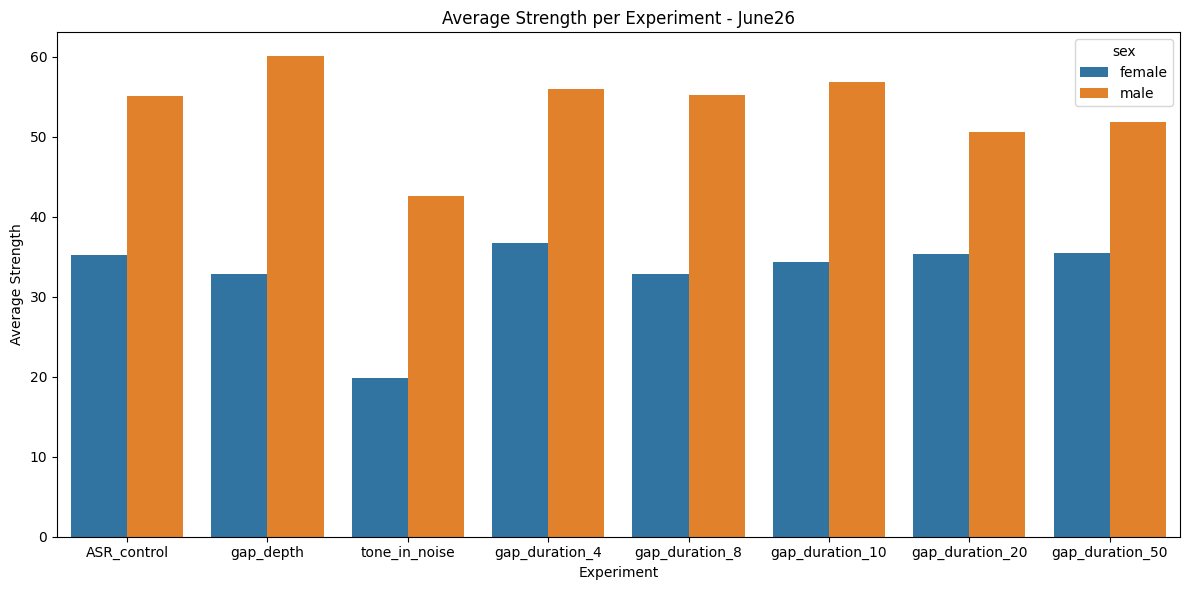

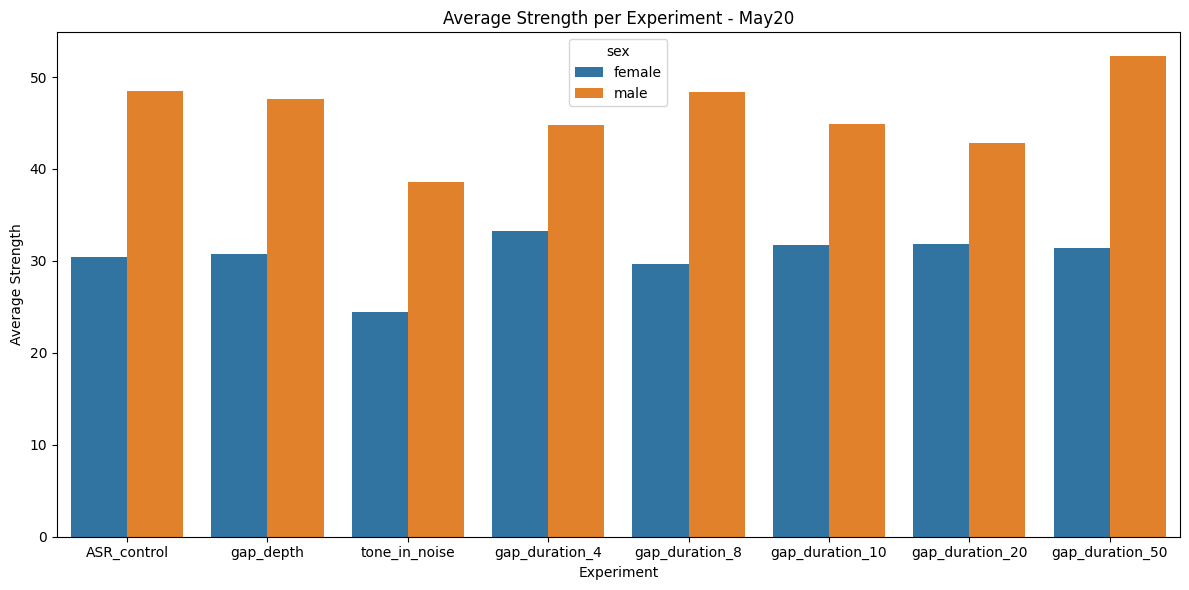

In [152]:
plot_results()
plot_results(strength=True)
plot_results(by_date=True)
plot_results(strength=True, by_date= True)

if df_top_10:
    print("Top 10:")
    plot_results(df=df_top_10)
    plot_results(df=df_top_10, strength=True)
    plot_results(df=df_top_10, by_date=True)
    plot_results(df=df_top_10, strength=True, by_date= True)